# Линейная классификация
Имеется набор 𝑁 векторов из двумерного пространства. Известно, что x, y координаты M векторов равномерно распределены на [0,1], а концы других 𝑁−𝑀 векторов образуют в пространстве ℝ2 кривую вида 𝑥2/𝑎2 + 𝑦2/𝑏2 + 𝑛 = 1, где n - нормальный шум с нулевым средним и дисперсией ≪𝑎,𝑏. Метки классов выставлены случайно неверно в 5% случаев для каждого класса.
- Необходимо разработать линейно-регрессионную модель, определяющая, к какому из двух классов принадлежит каждая точка из представленного множества.

Замечание:
- Алгоритм не должен опираться на априорные знания о виде описанной выше кривой.
## Постановка задачи
Данную задачу можно переформулировать иначе:
В двумерном пространстве дано N точек пренадлежащих 2-м классм.
- Первому классу пренадлежат точки пренадлежащие квадрату в верхней правой четверти со стороной 1  и координатами вершин (0,0), (0,1), (1,1) и (1,0).
- Второму классу пренадлежат точки лежащие на кольце в виде элепса ( где центр кольца это элипс с длиной a и шириной b) с шириной кольца 6*n (где n имеет нормальное распределение с мат.ожиданием 0 и дисперсией ≪ min(𝑎,𝑏)).

Так же известно что метки классов выставлены с ошибкой в 5%.

В качестве ЦФ возьмем среднее f1-меру между оценками для 0-го и 1-го класса.

Необходимо:
- Вариант 1:
- - Найти оптимальную прямую и минимальное количество точек переключения m, такие что ошибка на проверочной выборке была бы минимальной.
- Вариант 2:
- - Найти линейное преобразование при, котором линейное разделение даст минимальную ошибку на проверочной выборке.
## Решение
### Вариант 1
Вместо того чтобы искать плоскость которая обеспечит нам лучшее разбиение, будем искать матрицу поворота и значение X_separation в повернутой системе координат, которые обеспечат наилучшее разбиение на классы.

#### С чего начать поиск матрицы поворота?
Для того чтобы вычислить первое приближение оптимальной матрицы поворота:
- рассчитаем центры 0-го и 1-го класса (как среднее по каждой координате по всем точкам каждого из классов)
- найдем уравнение прямой проходящей через эти центры
- и из параметра наклона прямой вычислим угол для матрицы поворота

#### Определение X_separation
Для определения лучшего значения X_separation для разделения на классы используем равномерное разбиение области возможных значений X_separation с итеративным измельчением в области роста ЦФ.

#### Поиск оптимальной матрицы поворота
Для определения оптимальной матрицы поворота используе схожий подход что и для поиска лучшего X_separation, а именно:
- от первого приближения матрицы поворота отступим в каждую сторону на -pi/4 и +pi/4 обозначим это как область возможных значений для угла матрицы поворота
- далее с равномерным разбиением области возможных значений угла поворота с итеративным измельчением в области роста ЦФ определим лучший угол для матрицы поворота
#### Загрузка библиотек

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from scipy.stats.mstats import gmean
from scipy.stats.mstats import hmean
import math
from tqdm import tqdm

#### Вспомогательные функции
##### Функции для построения исходных данных

In [2]:
def make_test_data(N_num= 1000, a= 4, b= 2, proportion= 0.5 , error_proportion= 0.05, n_var = None):
    M_num = int(N_num*proportion)
    M_num_prop_x = int(b/(a+b)*M_num)
    M_num_prop_y = M_num - M_num_prop_x
    M = np.zeros([M_num,3])
    if n_var == None:
        n_var = np.min([a,b])/9
    n = np.random.normal(0, n_var, M_num)
    rand_sign = 2*(np.random.uniform(0, 1, [M_num,1])>0.5).astype(int)-1 
    rand_x = np.random.uniform(-a, a, M_num_prop_x)
    M[:M_num_prop_x,:2] = rand_sign[:M_num_prop_x]*np.array([rand_x, ellipseM_y(rand_x,a,b,n[:M_num_prop_x])]).T
    rand_y = np.random.uniform(-b, b, M_num_prop_y)
    M[M_num_prop_x:,:2] = rand_sign[M_num_prop_x:]*np.array([ellipseM_x(rand_y,a,b,n[M_num_prop_x:]), rand_y]).T
    M[:,2] = 1
    M[np.random.choice(M_num, int(M_num*error_proportion)), 2] = 0
    K_num = N_num - M_num
    K = np.concatenate((np.random.uniform(0,1,[K_num,2]), np.zeros([K_num,1])), axis=1)    
    K[np.random.choice(K_num, int(K_num*error_proportion)), 2] = 1
    return np.concatenate((M, K), axis=0)

def ellipseM_x(y,a,b,n):
    return a*(np.max([y*0, 1 - n - y**2/b**2], axis=0))**0.5

def ellipseM_y(x,a,b,n):
    return b*(np.max([x*0, 1 - n - x**2/a**2], axis=0))**0.5

##### Функции классификатора

In [3]:
# Поиск оптимального угла матрицы поворота
def find_best_slope(dat_train, dat_test, dat_val,iterations_slope,n_steps_slope,iterations_sep,n_steps_sep):
    X_train = dat_train[0]
    y_train = dat_train[1]
    point0 = np.mean(X_train[y_train==0,:],axis=0)
    point1 = np.mean(X_train[y_train==1,:],axis=0)
    a = func_par(point0, point1)
    theta = math.atan(a[0])
    best_rez = np.zeros(7)
    limits = (theta-math.pi/4, theta+math.pi/4)
    step = 0
    for iter in tqdm(range(iterations_slope)):
        rez=[]
        if iter>0:
            limits = (best_rez[6]-step, best_rez[6]+step)
        step = (limits[1]- limits[0])/n_steps_slope
        for t in np.arange(limits[0],step+limits[1],step):
            tmp = find_best_separation(dat_train, dat_test, dat_val,math.tan(t),iterations_sep,n_steps_sep)
            tmp.append(math.tan(t))
            rez.append(tmp)
        rez = np.array(rez)
        idx = np.argmax(rez[:,2])
        if best_rez[2]<rez[idx,2]:
            best_rez = rez[idx,:]
            scores = best_rez[:3]
            optimal_params = best_rez[3:]
    return scores, optimal_params

# Поиск оптимального X_separation
def find_best_separation(dat_train, dat_test, dat_val,a0,iterations,n_steps):
    X_train = dat_train[0]
    y_train = dat_train[1]
    X_test =  dat_test[0]
    y_test =  dat_test[1]
    X_val =   dat_val[0]
    y_val =   dat_val[1]
    
    Xr_train, Xr_shift= rotation_and_shift_y0(a0,X_train,y_train)
    Xr_test, _ = rotation_and_shift_Xshift(a0,X_test,Xr_shift)
    Xr_val, _ = rotation_and_shift_Xshift(a0,X_val,Xr_shift)
    best_rez = np.zeros(6)
    best_rez[4:] = Xr_shift
    limits = (np.max([np.min(Xr_train[y_train==0,0]),np.min(Xr_train[y_train==1,0])]),
              np.min([np.max(Xr_train[y_train==0,0]),np.max(Xr_train[y_train==1,0])]))
    step = 0
    for iter in range(iterations):
        rez=[]
        if iter>0:
            limits = (best_rez[3]-step, best_rez[3]+step)
        step = (limits[1]- limits[0])/n_steps
        for shift in np.arange(limits[0],step+limits[1],step):
            y_pred_train = np.zeros(y_train.shape)
            y_pred_train[(Xr_train[:,0]+shift)<=0] = 1
            y_pred_test = np.zeros(y_test.shape)
            y_pred_test[(Xr_test[:,0]+shift)<=0] = 1
            y_pred_val = np.zeros(y_val.shape)
            y_pred_val[(Xr_val[:,0]+shift)<=0] = 1
            rez.append(
                (f1_fixed(y_train,y_pred_train),
                 f1_fixed(y_test,y_pred_test),
                 f1_fixed(y_val,y_pred_val),
                 shift)
            )
        rez = np.array(rez)
        idx = np.argmax(rez[:,0])
        if best_rez[1]<rez[idx,1]:
            best_rez[:4] = rez[idx,:]
    return best_rez.tolist()

# Поворот
def rotation(a0,X0):
    theta= math.atan(a0)
    mx = np.array(((math.cos(theta), math.sin(theta)),(-1*math.sin(theta), math.cos(theta))))
    return mx.dot(X0.T).T

# Поворот со смещением (вычисляемым как среднее между центрами классов)
def rotation_and_shift_y0(a0, X0, y0):
    X02 = rotation(a0,X0)
    X_shift= np.mean((np.mean(X02[y0==0,:],axis=0),np.mean(X02[y0==1,:],axis=0)),axis=0)
    return X02 - X_shift, X_shift

# Поворот со смещением (которое дано)
def rotation_and_shift_Xshift(a0, X0, X_shift):
    X02 = rotation(a0,X0)
    return X02 - X_shift, X_shift

# Поворот со смещением (вычисляемым как среднее по всем точкам)
def rotation_and_shift(a0, X0):
    X02 = rotation(a0,X0)
    X_shift= np.mean(X02,axis=0)
    return X02 - X_shift, X_shift

# Определение параметров прямой проходящей через две данные точки
def func_par(X0, X1):
    a = (X0[1]-X1[1])/(X0[0]-X1[0])
    return (a, X0[1]-a*X0[0])

# Предсказание класса(на основании параметров оптимизации) на предоставленных данных X
def calc_pred(X, optimal_params):
    optim_shift, optim_Xr_shift1, optim_Xr_shift2, optim_slope = optimal_params
    Xr,_ = rotation_and_shift_Xshift(optim_slope,X,(optim_Xr_shift1,optim_Xr_shift2))
    y_pred = np.zeros(X.shape[0])
    y_pred[(Xr[:,0]+optim_shift)<=0] = 1
    return y_pred

# Расчет средней f1-меры (как среднего из оценок f1-меры для каждого из классов)
def f1_fixed(y_real,y_pred):
    tp = np.max([10e-10,np.sum((y_pred[y_real==0]==0).astype(int))])
    fn = np.max([10e-10,np.sum((y_pred[y_real==0]==1).astype(int))])
    fp = np.max([10e-10,np.sum((y_pred[y_real==1]==0).astype(int))])
    tn = np.max([10e-10,np.sum((y_pred[y_real==1]==1).astype(int))])
    pre = tp/(tp+fp)
    rec = tp/(tp+fn)
    pre2 = tn/(tn+fp)
    rec2 = tn/(tn+fn)
    f1 = 2*pre*rec/(pre+rec)
    f1_2 = 2*pre2*rec2/(pre2+rec2)
    return (f1+f1_2)/2

#### Входные данные

In [4]:
# Генерация исходных данных
N = make_test_data(
                    2000, # - общее количество точек
                    4,    # - размер элепса по x
                    2,    # - размер элепса по y
                    0.5,  # - соотношение между классами пренадлежащими квадрату и элепсу
                    0.05, # - доля ошибочных отметок класса
                    0.1 # - разброс относительно среднего элепса
                )
# Разделение данных
X = N[:,:2] # - координаты
y = N[:,2]  # - метки классов

#### Разделение на проверочную и обучающую выборки
Здесь произведем разделение на проверочную и обучающую выборки.

Однако обучающую выборку так же разобьем на несколько независимых частей, так чтобы выборы которые приходится предпренимать в процессе оптимизации базировались на не связных друг с другом выборках.

In [5]:
# ключ случайного генератора
r_state = 71

# Выделение валидационной выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.20, random_state=r_state)

# Разбиение обучающих данных на 3 независимые части
X_tr1, X_tr0, y_tr1, y_tr0 = train_test_split(X_train, y_train, stratify=y_train, test_size=1/3, random_state=r_state)
X_tr2, X_tr3, y_tr2, y_tr3 = train_test_split(X_tr0, y_tr0, stratify=y_tr0, test_size=0.5, random_state=r_state)
dat_tr1 = (X_tr1,y_tr1)
dat_tr2 = (X_tr2,y_tr2)
dat_tr3 = (X_tr3,y_tr3)

#### Обучение классификатора

In [6]:
(scores, optimal_params) = find_best_slope(
                                            (X_tr1,y_tr1), # - данные для поиска первого приближения
                                            (X_tr2,y_tr2), # - данные для определения оптимального X_separation
                                            (X_tr3,y_tr3), # - данные для определения оптимального угла поворота
                                            10, # - количество итераций измельчения для поиска угла поворота
                                            10, # - количество равных шагов разбиения при поиске угла поворота
                                            10, # - количество итераций измельчения для поиска X_separation
                                            10  # - количество равных шагов разбиения при поиске X_separation
                                          )

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.48it/s]


#### Проверка качества полученной модели
##### Качество рассматриваемого классификатора

f1-score (validation data): 0.6894


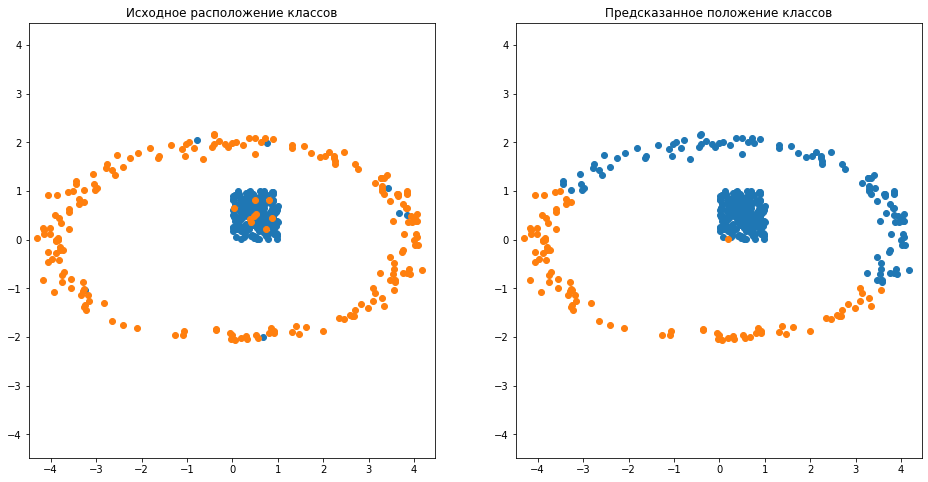

In [7]:
y_pred = calc_pred(X_val, optimal_params)

lim0 = (np.min(X[:,0]),np.max(X[:,0]))
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.scatter(X_val[y_val==0,0],X_val[y_val==0,1])
ax1.scatter(X_val[y_val==1,0],X_val[y_val==1,1])
ax1.set_xlim(lim0)
ax1.set_ylim(lim0)
ax1.title.set_text('Исходное расположение классов')

ax2 = fig.add_subplot(122)
ax2.scatter(X_val[y_pred==0,0],X_val[y_pred==0,1])
ax2.scatter(X_val[y_pred==1,0],X_val[y_pred==1,1])
ax2.set_xlim(lim0)
ax2.set_ylim(lim0)
ax2.title.set_text('Предсказанное положение классов')

print('f1-score (validation data): ' + str(round(f1_fixed(y_val, y_pred),4)))

##### Сравнение с другими классификаторами

In [8]:
C = 1.0  # = self._alpha in our algorithm
model1 = svm.SVC(kernel='linear', C=C).fit(X_train, y_train)
model2 = svm.LinearSVC(C=C, max_iter=10000).fit(X_train, y_train)

f1-score (validation data): 0.6426


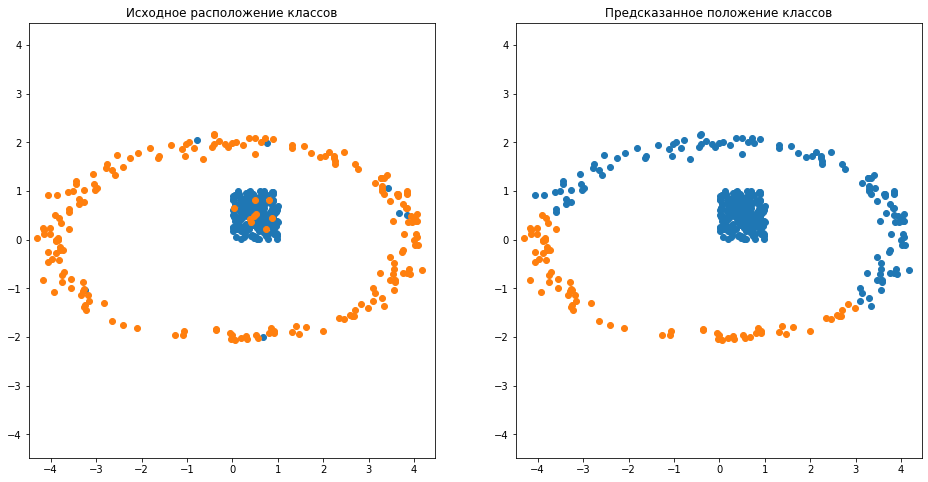

In [9]:
y_p_m1 = model1.predict(X_val)

lim0 = (np.min(X[:,0]),np.max(X[:,0]))
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.scatter(X_val[y_val==0,0],X_val[y_val==0,1])
ax1.scatter(X_val[y_val==1,0],X_val[y_val==1,1])
ax1.set_xlim(lim0)
ax1.set_ylim(lim0)
ax1.title.set_text('Исходное расположение классов')

ax2 = fig.add_subplot(122)
ax2.scatter(X_val[y_p_m1==0,0],X_val[y_p_m1==0,1])
ax2.scatter(X_val[y_p_m1==1,0],X_val[y_p_m1==1,1])
ax2.set_xlim(lim0)
ax2.set_ylim(lim0)
ax2.title.set_text('Предсказанное положение классов')

print('f1-score (validation data): ' + str(round(f1_fixed(y_val, y_p_m1),4)))

f1-score (validation data): 0.668


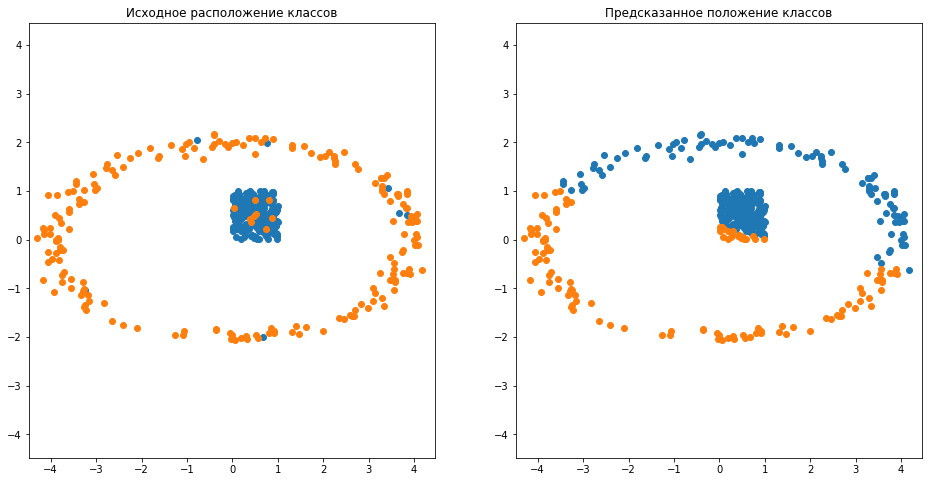

In [10]:
y_p_m2 = model2.predict(X_val)

lim0 = (np.min(X[:,0]),np.max(X[:,0]))
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.scatter(X_val[y_val==0,0],X_val[y_val==0,1])
ax1.scatter(X_val[y_val==1,0],X_val[y_val==1,1])
ax1.set_xlim(lim0)
ax1.set_ylim(lim0)
ax1.title.set_text('Исходное расположение классов')

ax2 = fig.add_subplot(122)
ax2.scatter(X_val[y_p_m2==0,0],X_val[y_p_m2==0,1])
ax2.scatter(X_val[y_p_m2==1,0],X_val[y_p_m2==1,1])
ax2.set_xlim(lim0)
ax2.set_ylim(lim0)
ax2.title.set_text('Предсказанное положение классов')

print('f1-score (validation data): ' + str(round(f1_fixed(y_val, y_p_m2),4)))

##### Результат сравнения
Как можно видеть, предложенный метод классификации по качеству превосходит прочии методы (в постановке варианта 1).
### Вариант 2
Преобразуем входные данные к полярным координатам, а затем произведем поиск разделяющей классы прямой.
#### Вспомогательные функции

In [11]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return np.concatenate((rho.reshape((rho.shape[0],1)), phi.reshape((phi.shape[0],1))),axis=1)

#### Преобразование к полярным координатам

In [12]:
Xp_val =cart2pol(X_val[:,0],X_val[:,1])
Xp_tr1 =cart2pol(X_tr1[:,0],X_tr1[:,1])
Xp_tr2 =cart2pol(X_tr2[:,0],X_tr2[:,1])
Xp_tr3 =cart2pol(X_tr3[:,0],X_tr3[:,1])

#### Обучение классификатора

In [13]:
rez = find_best_separation((Xp_tr3,y_tr3), (Xp_tr2,y_tr2), (Xp_tr1,y_tr1),0,10,10)

#### Проверка качества полученной модели
##### Качество рассматриваемого классификатора

f1-score (validation data): 0.897


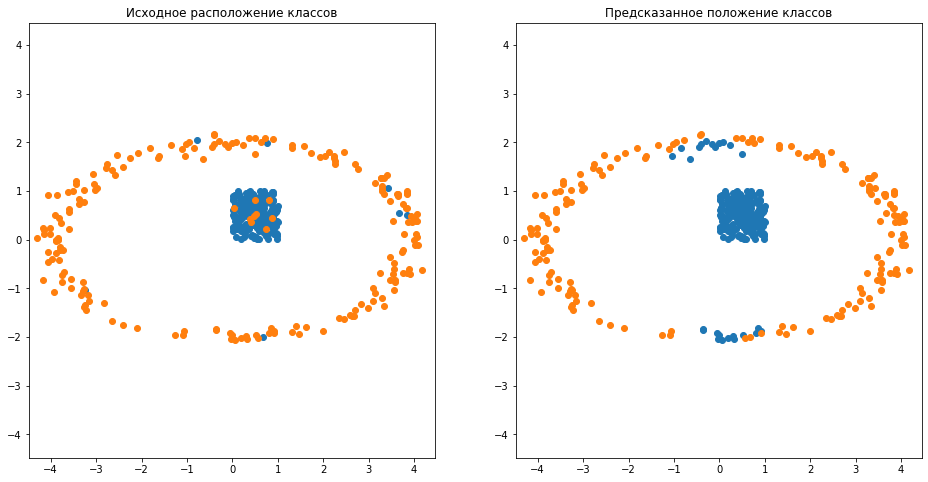

In [14]:
y_pred = np.zeros(y_val.shape)
y_pred[Xp_val[:,0]>=rez[3]]=1

lim0 = (np.min(X[:,0]),np.max(X[:,0]))
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.scatter(X_val[y_val==0,0],X_val[y_val==0,1])
ax1.scatter(X_val[y_val==1,0],X_val[y_val==1,1])
ax1.set_xlim(lim0)
ax1.set_ylim(lim0)
ax1.title.set_text('Исходное расположение классов')

ax2 = fig.add_subplot(122)
ax2.scatter(X_val[y_pred==0,0],X_val[y_pred==0,1])
ax2.scatter(X_val[y_pred==1,0],X_val[y_pred==1,1])
ax2.set_xlim(lim0)
ax2.set_ylim(lim0)
ax2.title.set_text('Предсказанное положение классов')

print('f1-score (validation data): ' + str(round(f1_fixed(y_val, y_pred),4)))

##### Сравнение с другими классификаторами

In [15]:
C = 1.0  # = self._alpha in our algorithm
model3 = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X_train, y_train)
model4 = svm.SVC(kernel='poly', degree=3, gamma='auto', C=C).fit(X_train, y_train)

f1-score (validation data): 0.96


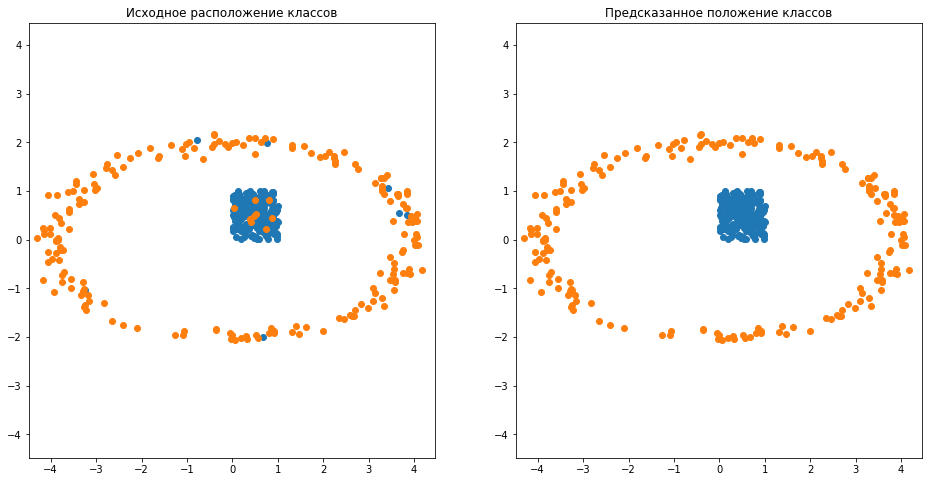

In [16]:
y_p_m3 = model3.predict(X_val)

lim0 = (np.min(X[:,0]),np.max(X[:,0]))
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.scatter(X_val[y_val==0,0],X_val[y_val==0,1])
ax1.scatter(X_val[y_val==1,0],X_val[y_val==1,1])
ax1.set_xlim(lim0)
ax1.set_ylim(lim0)
ax1.title.set_text('Исходное расположение классов')

ax2 = fig.add_subplot(122)
ax2.scatter(X_val[y_p_m3==0,0],X_val[y_p_m3==0,1])
ax2.scatter(X_val[y_p_m3==1,0],X_val[y_p_m3==1,1])
ax2.set_xlim(lim0)
ax2.set_ylim(lim0)
ax2.title.set_text('Предсказанное положение классов')

print('f1-score (validation data): ' + str(round(f1_fixed(y_val, y_p_m3),4)))

f1-score (validation data): 0.5341


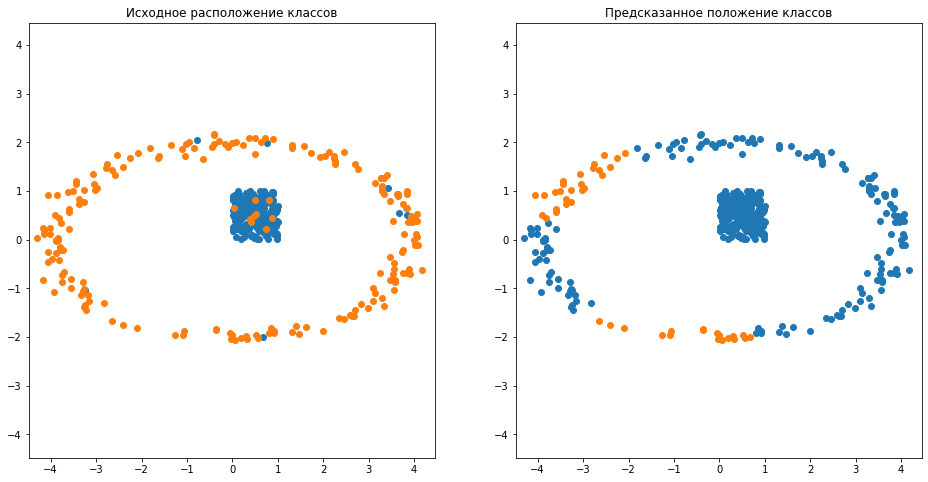

In [17]:
y_p_m4 = model4.predict(X_val)

lim0 = (np.min(X[:,0]),np.max(X[:,0]))
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.scatter(X_val[y_val==0,0],X_val[y_val==0,1])
ax1.scatter(X_val[y_val==1,0],X_val[y_val==1,1])
ax1.set_xlim(lim0)
ax1.set_ylim(lim0)
ax1.title.set_text('Исходное расположение классов')

ax2 = fig.add_subplot(122)
ax2.scatter(X_val[y_p_m4==0,0],X_val[y_p_m4==0,1])
ax2.scatter(X_val[y_p_m4==1,0],X_val[y_p_m4==1,1])
ax2.set_xlim(lim0)
ax2.set_ylim(lim0)
ax2.title.set_text('Предсказанное положение классов')

print('f1-score (validation data): ' + str(round(f1_fixed(y_val, y_p_m4),4)))

##### Результат сравнения
Как можно видеть, предложенный метод классификации по качеству не уступает классификатору SVC (причем в его нелинейной версии).